In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
df = pd.read_csv('churn_data.csv')
df.head(20)

,uuid,date,event
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact
5,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,big_purchase
6,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-05-16,small_purchase
7,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-05,contact
8,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-14,contact
9,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-07-11,contact


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104103 entries, 0 to 104102
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   uuid    104103 non-null  object
 1   date    104103 non-null  object
 2   event   104103 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


## EDA

In [4]:
print("Number of Events: ",df.shape[0])
print("Number of Unique Users: ",df.uuid.nunique())
print("Type of Events: ", df.event.unique()[0:3].tolist())

Number of Events:  104103
Number of Unique Users:  1034
Type of Events:  ['small_purchase', 'contact', 'big_purchase']


In [5]:
df['date'] = pd.to_datetime(df['date'])
df['monthYear'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.to_period('M')


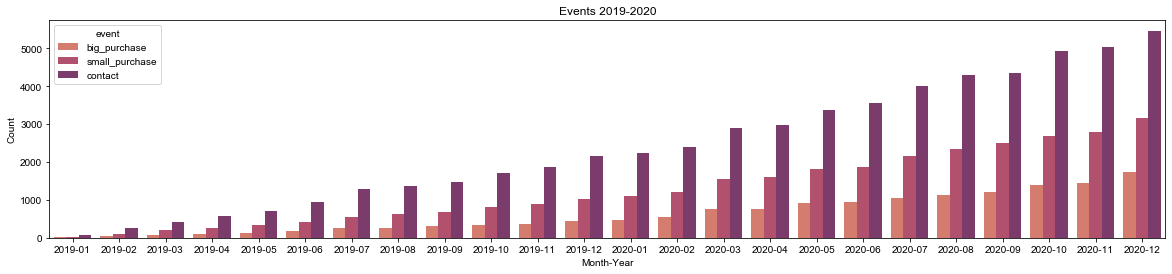

In [6]:
plt.figure(figsize=(20,4))
ax = sns.countplot(data=df.sort_values(by='monthYear',ascending=True),x="monthYear", 
                   hue="event",hue_order=['big_purchase','small_purchase','contact']
                   ,palette="flare")
sns.set(style="whitegrid")
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.title('Events 2019-2020')
plt.show()

## Interval Between Events

In [7]:
intervalBetweenEvents = []
intervalBetweenEvents.append(0)

for row in range(1,len(df)):
    if df.uuid[row] == df.uuid[row-1]:
        diffDates = abs(df.date[row] - df.date[(row-1)]).days
        intervalBetweenEvents.append(diffDates)
    else: intervalBetweenEvents.append(0)

df['interval'] = intervalBetweenEvents

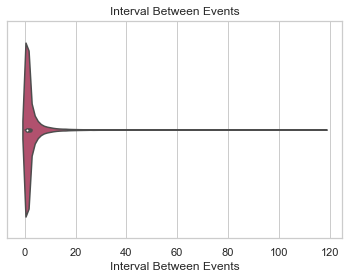

In [8]:
ax = sns.violinplot(data=df, x='interval',palette='flare')
plt.xlabel('Interval Between Events')
plt.title('Interval Between Events')
plt.show()

Calculating the optimal cut off date for determine customers that churned

In [9]:
def calcChurnFP(interval):
    falsePositive = df[df.interval > interval]['uuid'].nunique()
    return print("False Positive:",falsePositive)

def calcChurnFPPerc(interval):
    falsePositive = df[df.interval > interval]['uuid'].nunique()
    numberUsers = df.uuid.nunique()
    return print("Percentage:",round((falsePositive/numberUsers)*100,2))

In [10]:
#calculating FP depending of interval
for i in range(60,95,5):
    print("Interval:",i," days")
    calcChurnFP(i)
    calcChurnFPPerc(i)
    print("-----------------------")

Interval: 60  days
False Positive: 40
Percentage: 3.87
-----------------------
Interval: 65  days
False Positive: 27
Percentage: 2.61
-----------------------
Interval: 70  days
False Positive: 21
Percentage: 2.03
-----------------------
Interval: 75  days
False Positive: 13
Percentage: 1.26
-----------------------
Interval: 80  days
False Positive: 8
Percentage: 0.77
-----------------------
Interval: 85  days
False Positive: 5
Percentage: 0.48
-----------------------
Interval: 90  days
False Positive: 3
Percentage: 0.29
-----------------------


In [22]:
#creating churn feature in the dataset
cutOffDate = 55
df['churn'] = [1 if x > cutOffDate else 0 for x in df.interval]
df.churn.value_counts(normalize=True)

0    0.999462
1    0.000538
Name: churn, dtype: float64

In [12]:
print("Percentage of Customers that Churn: ", round((len(df[df.churn == 1])/df.uuid.nunique())*100,2), "%")

Percentage of Customers that Churn:  5.42 %


## Feature Engineering

In [13]:
# categorical column
df.event.value_counts()

contact           58406
small_purchase    30741
big_purchase      14956
Name: event, dtype: int64

In [14]:
#making a column for each category to sum events by categories
df['contact'] = [1 if x == 'contact' else 0 for x in df.event]
df['small_purchase'] = [1 if x == 'small_purchase' else 0 for x in df.event]
df['big_purchase'] = [1 if x == 'big_purchase' else 0 for x in df.event]


In [15]:
df.head()

,uuid,date,event,monthYear,interval,churn,contact,small_purchase,big_purchase
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,0,0,0,1,0
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,13,0,0,1,0
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,51,0,1,0,0
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,7,0,1,0,0
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,11,0,1,0,0


In [16]:
# aggregating columns and making a new dataframe (unique user for row)
sumTypeEvents = df.groupby(['uuid'])[['contact','small_purchase','big_purchase']].agg('sum').reset_index()
meanInterval = df.groupby(['uuid'])['interval'].agg('mean').reset_index()
lastDate = df.groupby(['uuid'])['date'].last().reset_index()

dfUsers = pd.merge(pd.merge(sumTypeEvents,meanInterval,on='uuid'),lastDate,on='uuid')


In [17]:
dfUsers.head()

,uuid,contact,small_purchase,big_purchase,interval,date
0,00038504-c286-4c49-a6ed-d7853f65f7d6,7,3,1,14.090909,2019-07-12
1,0012c23d-379a-43fb-a91b-6f95c5358f52,40,11,7,7.948276,2020-12-27
2,0076823a-041d-4fa0-a19c-0e6e63bcef76,3,2,1,7.333333,2019-12-16
3,017c823f-e985-40b9-8e61-81eed835e3e2,82,41,12,1.637037,2020-12-28
4,0183fced-42c4-4379-894a-d8ec09c184e4,15,8,3,6.653846,2020-12-31


In [19]:
from datetime import date

dayCalcChurn = pd.to_datetime(date(2021,1,1)) #first day of 2021 - to calculate probability of churn

daysLastEvent = []
for i in range(0,len(dfUsers)):
    diffDaysLast = abs(dayCalcChurn - dfUsers.date[i]).days
    daysLastEvent.append(diffDaysLast)

dfUsers['days_last_event'] = daysLastEvent


In [20]:
dfUsers.head()

,uuid,contact,small_purchase,big_purchase,interval,date,days_last_event
0,00038504-c286-4c49-a6ed-d7853f65f7d6,7,3,1,14.090909,2019-07-12,539
1,0012c23d-379a-43fb-a91b-6f95c5358f52,40,11,7,7.948276,2020-12-27,5
2,0076823a-041d-4fa0-a19c-0e6e63bcef76,3,2,1,7.333333,2019-12-16,382
3,017c823f-e985-40b9-8e61-81eed835e3e2,82,41,12,1.637037,2020-12-28,4
4,0183fced-42c4-4379-894a-d8ec09c184e4,15,8,3,6.653846,2020-12-31,1


In [24]:
len(dfUsers[dfUsers.days_last_event > cutOffDate])/len(dfUsers)

0.3239845261121857